Example usage of the ofset free koopman MPC

In [203]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from sklearn.preprocessing import StandardScaler

from neuromancer.system import Node, System
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks

import src.models as models
import src.helper as helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get the data

In [204]:
A1 = 1
A2 = 0.5
k1 = 0.5
k2 = 0.8

TwoTanks = models.TwoTanks(True, A1, A2, k1, k2)

In [205]:
# example simulation
sim_time = 500
Ts = 1
h1 = 1
h2 = 0.5
h0 = [h1, h2]
u = np.ones((sim_time,2))*0.5


sim = TwoTanks.simulate(h0, u, Ts)


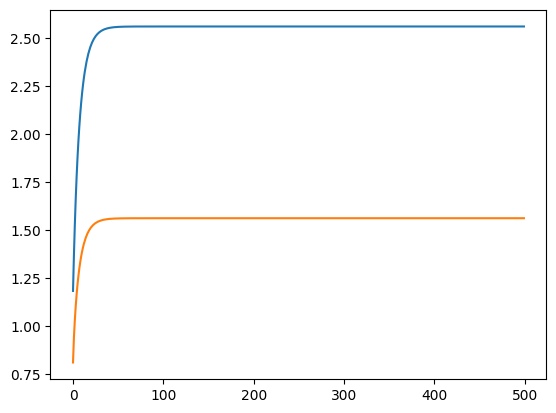

In [206]:
plt.plot(sim["Y"])

Getting the step changes data

In [207]:
constrains = np.array([[0, 0.5], [0, 1]])
step_time = 100
no_steps = 100
steps = helper.generate_steps(step_time, no_steps, constrains)

In [208]:
Ts = 1
h1 = 1
h2 = 0.5
u1 = steps[0,:]
u2 = steps[1,:]

sim = TwoTanks.simulate([h1, h2], steps, Ts)

In [209]:
# add noise to sim data
np.random.seed(0)
noise = np.random.normal(0, 0.1, sim["Y"].shape)
sim["Y"] += noise

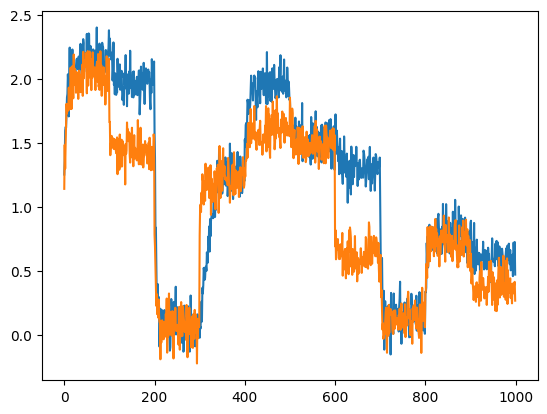

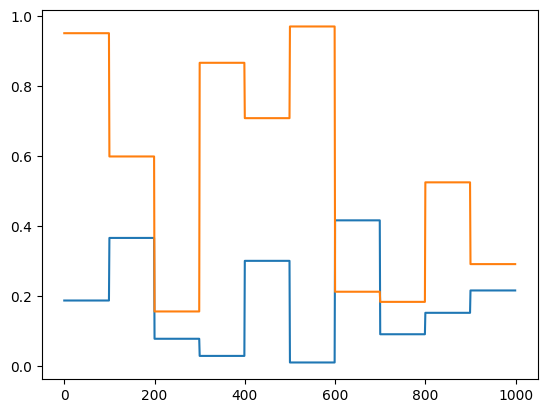

In [210]:
part = 1000
plt.plot(sim["Y"][:part])

plt.figure()
plt.plot(sim["U"][:part])

Preparing data for training koopman models

In [211]:
def get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU):
    
    ny = train_sim['Y'].shape[1]
    nu = train_sim['U'].shape[1]
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, ny)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    nsim = test_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, ny)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}
    
    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(1, nbatch*nsteps, ny)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(1, nbatch*nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data_forC = {'Y': trainX, 'Y0': trainX[:, 0:1, :],
                 'U': trainU}

    return train_loader, dev_loader, test_data, train_data_forC

In [212]:
train_sim = {key: value[:5000] for key, value in sim.items()}
test_sim = {key: value[7000:] for key, value in sim.items()}
dev_sim = {key: value[5000:7000] for key, value in sim.items()}

nsteps = 80   # number of prediction horizon steps in the loss function
bs = 80      # minibatching batch size

In [213]:
# fit and save scalers for scaling the data on train dataset
scaler = StandardScaler()
scaler.fit(train_sim['Y'])  
joblib.dump(scaler, 'data/scaler.pkl')

scalerU = StandardScaler()
scalerU.fit(train_sim['U'])
joblib.dump(scalerU, 'data/scalerU.pkl')


['data/scalerU.pkl']

In [214]:
train_loader, dev_loader, test_data, train_data = get_data(train_sim, dev_sim, test_sim, nsteps, bs, scaler, scalerU)

Creating the model


In [215]:
# model parameters
nz = 10
ny = train_sim['Y'].shape[1]
nu = train_sim['U'].shape[1]

layers = [20,40,60]
layers_dec  = [60,40,20]

matrix_C = False

In [216]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [217]:
# instantiate input encoder net f_u, representing the B matrix in the linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [218]:
# instantiate state decoder neural net f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(nz, ny, bias=True,
                    linear_map=torch.nn.Linear,
                    nonlin=torch.nn.ELU,
                    hsizes=layers_dec)
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

In [219]:
# representing matrix A in the linear system
K = torch.nn.Linear(nz, nz, bias=False)

In [220]:
# symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [221]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

Define Koopman system identification loss function terms

In [222]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 20.*(yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"

Construct System learning problem

In [223]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

Solve the problem

In [224]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=200,
    warmup=100,
    epochs=2000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [225]:
# train

best_model = trainer.train()
problem.load_state_dict(best_model)


epoch: 0  train_loss: 29.361003875732422
epoch: 1  train_loss: 28.659465789794922
epoch: 2  train_loss: 27.97254180908203
epoch: 3  train_loss: 27.297664642333984
epoch: 4  train_loss: 26.629680633544922
epoch: 5  train_loss: 25.963096618652344
epoch: 6  train_loss: 25.29454803466797
epoch: 7  train_loss: 24.62251853942871
epoch: 8  train_loss: 23.945518493652344
epoch: 9  train_loss: 23.261552810668945
epoch: 10  train_loss: 22.569652557373047
epoch: 11  train_loss: 21.87099266052246
epoch: 12  train_loss: 21.166179656982422
epoch: 13  train_loss: 20.454965591430664
epoch: 14  train_loss: 19.7390079498291
epoch: 15  train_loss: 19.021121978759766
epoch: 16  train_loss: 18.303953170776367
epoch: 17  train_loss: 17.5914249420166
epoch: 18  train_loss: 16.885372161865234
epoch: 19  train_loss: 16.185123443603516
epoch: 20  train_loss: 15.48839282989502
epoch: 21  train_loss: 14.790853500366211
epoch: 22  train_loss: 14.083781242370605
epoch: 23  train_loss: 13.36046314239502
epoch: 24  t

<All keys matched successfully>

In [232]:
# save model
torch.save(best_model, "./data/model_C_" + str(matrix_C) + ".pth")

# pull and save matrices
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()
if matrix_C:
    C = f_y_inv.weight.detach().numpy()
    
elif not matrix_C:
    # get approximate C matrix from training data
    problem.nodes[3].nsteps = train_data['Y'].shape[1]
    train_outputs = problem.step(train_data)

    Y = train_data['Y'].reshape(-1, ny).detach().numpy()
    Z = train_outputs['x'][:,:-1,:].detach().numpy().reshape(-1, nz)
    rankZ = np.linalg.matrix_rank(Z)
    if rankZ < nz:
        print('Rank deficient Z matrix, can result in bad fitted C matrix!')
    C, residuals, rank, s = np.linalg.lstsq(Z, Y, rcond=None)
    C = C.T

else:
    raise ValueError('matrix_C must be boolean')

In [233]:
np.save('./data/A_C_' + str(matrix_C) + '.npy', A)
np.save('./data/B_C_' + str(matrix_C) + '.npy', B)
np.save('./data/C_C_' + str(matrix_C) + '.npy', C)

Evaluation of the training

In [234]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = test_data['Y'].shape[1]

In [235]:
# do the prediction
test_outputs = problem.step(test_data)

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, ny).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, ny).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T
pred_x = test_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nz).T

In [236]:
pred_traj_C = np.dot(C, pred_x)

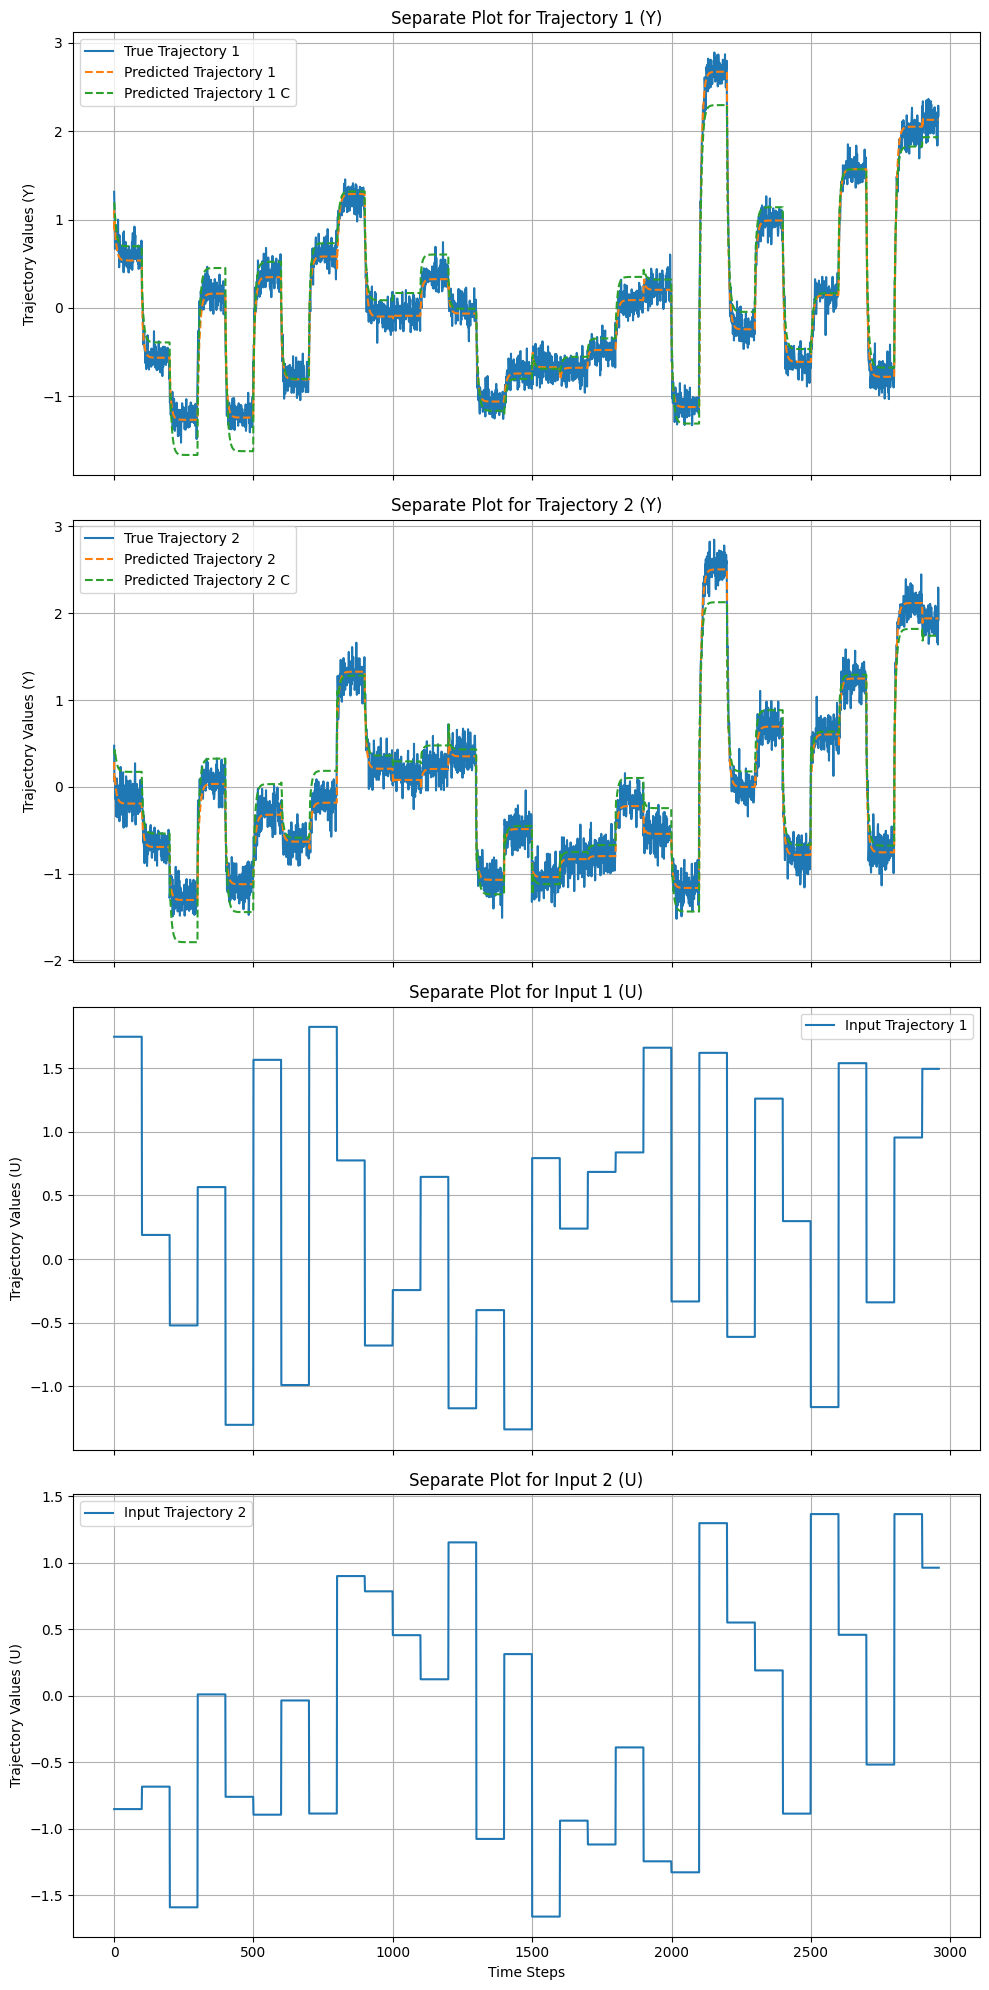

In [237]:
fig, axs = plt.subplots(ny + nu, 1, figsize=(10, 5 * (ny + nu)), sharex=True)

# Separate plots for each vector in Y
for i in range(ny):
    axs[i].plot(true_traj[i], label=f'True Trajectory {i + 1}', linestyle='-')
    axs[i].plot(pred_traj[i], label=f'Predicted Trajectory {i + 1}', linestyle='--')
    axs[i].plot(pred_traj_C[i], label=f'Predicted Trajectory {i + 1} C', linestyle='--')
    axs[i].set_title(f'Separate Plot for Trajectory {i + 1} (Y)')
    axs[i].legend()
    axs[i].grid()

# Separate plots for each vector in U
for i in range(nu):
    axs[ny + i].plot(input_traj[i], label=f'Input Trajectory {i + 1}', linestyle='-')
    axs[ny + i].set_title(f'Separate Plot for Input {i + 1} (U)')
    axs[ny + i].legend()
    axs[ny + i].grid()

# Add labels
axs[-1].set_xlabel('Time Steps')
for i in range(ny):
    axs[i].set_ylabel('Trajectory Values (Y)')
for i in range(nu):
    axs[ny + i].set_ylabel('Trajectory Values (U)')

plt.tight_layout()
plt.show()
